In [1]:
import jax
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

# os.environ['JAX_PLATFORMS'] = 'cpu'
# jax.config.update("jax_platform_name", "cpu")
# jax.default_device(jax.devices("cpu")[0])

In [2]:

import jax.numpy as jnp
import jax
from tqdm import tqdm
from functools import partial
import h5py
import numpy as np


@partial(jax.jit, static_argnames=['dtype'])
def jax_count(spike_times, bin_edges, dtype=jnp.uint32):
    num_bins = bin_edges.size - 1
    idx = jnp.searchsorted(bin_edges, spike_times, side="right") - 1
    counts = jnp.bincount(idx, length=num_bins)

    return jax.lax.convert_element_type(counts, dtype)

def nwb_spike_count(file, interval, window, batchsize=None, dtype=jnp.uint32, save=False):
    T = interval[1] - interval[0]
    N = int(T // window)
    if save:
        readmode = "a"
    else:
        readmode = "r"
    with h5py.File(file, readmode) as data:
        spike_times = data['units']['spike_times'][:] # * [:] Loads the entire file at once
        units = len(data['units']['id'])
        indices = data['units']['spike_times_index']

        cpus = jax.devices("cpu")

        bin_edges = jnp.linspace(interval[0]-window, interval[1], N + 2) # Add an extra bin to count less-than spikes

        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        def indices2idxs(i):
            minidx = indices[i]
            maxidx = indices[i+1] if i < units - 1 else len(spike_times)
            return range(minidx, maxidx)

        if batchsize is not None:
            nbatches = np.ceil(units / batchsize)
        else:
            nbatches = 1

        batchis = np.arange(units)
        # numspikes = [indices[i+1] - indices[i] for i in range(units)-1]
        # numspikes.append(len(spike_times) - indices[-1])
        # batchis = np.argsort(numspikes)
        # batchis = np.argsort([len(spike_times[indices2idxs(i)]) for i in batchis])
        batchis = np.array_split(batchis, nbatches)

        @jax.jit
        def _count(spike_times):
            return jax_count(spike_times, bin_edges, dtype)

        def count(batchi):
            # * Get spike times for a batch
            batch = [spike_times[indices2idxs(i)] for i in batchi]

            # * Pad the batch with NaN's for JaX
            maxlen = max([len(b) for b in batch])
            batch = [jnp.pad(b, (0, maxlen - len(b)), constant_values=np.nan) for b in batch]
            batch = jnp.stack(batch)

            counts = jax.vmap(_count)(batch)
            cpucounts = jax.device_put(counts, cpus[0])

            batch.delete() # Free up gpu memory
            counts.delete()
            return cpucounts


        if save:
            if 'counts' in data:
                del data['counts']
            if 'bin_centers' in data:
                del data['bin_centers']
            data.create_dataset("counts", data=np.zeros((units, N), dtype=dtype))
            for batchi in tqdm(batchis):
                counts_batch = count(batchi)
                data["counts"][batchi, :] = counts_batch[:, 1:]
            data.create_dataset("bin_centers", data=np.array(bin_centers[1:]))
            return file
        else:
            counts = [count(batchi) for batchi in tqdm(batchis)]
            X = jnp.concatenate(counts, axis=0)
            return X[:, 1:], bin_centers[1:]


In [3]:
dummy_spike_times = jnp.zeros((1, 1000))
dummy_bin_edges = jnp.linspace(0, 100, 101)
_ = jax.vmap(lambda x: jax_count(x, dummy_bin_edges))(dummy_spike_times)


In [ ]:
batchsize=500
interval = (0, 9600)
spike_counts, ts = nwb_spike_count("test.nwb", interval, 0.002, batchsize, dtype=jnp.uint8, save=False)
# spike_counts, ts = nwb_spike_count("test.nwb", interval, 0.002, batchsize, dtype=jnp.uint8, save=False)

jax.profiler.save_device_memory_profile(f"memory_{batchsize}.prof")

100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


In [5]:
# %load_ext line_profiler
# %lprun -f nwb_spike_count nwb_spike_count("test.nwb", (0, 9600), 0.005, batchsize=100, dtype=jnp.uint8, save=False)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import jax
import nemos as nmo
from tqdm import tqdm

nap.nap_config.suppress_conversion_warnings = True

import optax


def batcher(counts, times, basis, interval, batch_size: int=10):
    # Grab a random time within the time support. Here is the time support is one epoch only so it's easy.
    t = np.random.uniform(interval[0], interval[1]-batch_size)

    # Find indices of times within batch window
    indices = np.where((times >= t) & (times < t+batch_size))[0]
    counts = counts[:, indices]

    gpucounts = jax.device_put(counts, jax.devices("gpu")[0])
    X = basis.compute_features(gpucounts)

    counts.delete()

    return X, gpucounts


class OptState:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.grad_fn = jax.grad(self.loss_fn)

    def update(self, data, y, *args, **kwargs):
        # l = self.loss_fn(self.params, data, y, *args, **kwargs)
        grad = self.grad_fn(self.params, data, y, *args, **kwargs)
        return self.apply_update(grad)

    def apply_update(self, grads):
        updates, opt_state = self.tx.update(grads, self.opt_state, self.params)
        params = optax.apply_updates(self.params, updates)

        self.step += 1
        self.params = params
        self.opt_state = opt_state

        # return self.params
        # return updates, self.params
        return self.params, updates

    @classmethod
    def create(cls, loss_fn, params, tx, **kwargs):
        opt_state = tx.init(params)
        return cls(step=0,
                   loss_fn=loss_fn,
                   params=params,
                   tx=tx,
                   opt_state=opt_state,
                   **kwargs)

def wrap_initialize_state(inst, params, **kwargs):

    loss_fn = inst._predict_and_compute_loss

    tx = optax.sgd(**kwargs)
    opt_state = OptState.create(
        loss_fn=loss_fn,
        params=params,
        tx=tx
    )
    return opt_state


def wrap_solver_update(_, opt_state: OptState, data, y, *args, **kwargs):
    return opt_state.update(data, y, *args, **kwargs)


class WrapGLM(nmo.glm.PopulationGLM):
    def initialize_state(self, params, **kwargs) -> OptState:
        self._solver_update = wrap_solver_update
        return wrap_initialize_state(self, params, **kwargs)

    @property
    def solver_update(self):
        return self._solver_update




  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


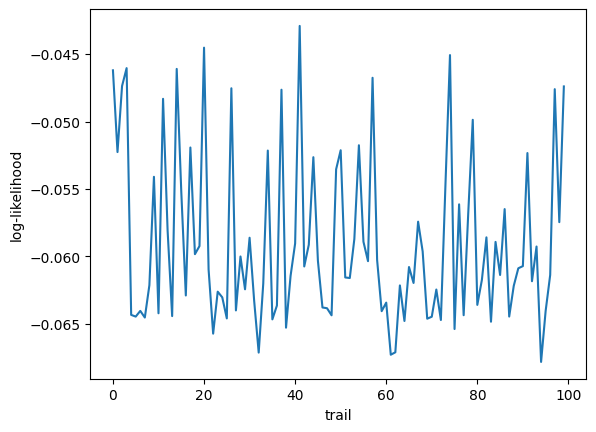

In [13]:
batch_size = 10
nstep=100

# initialize basis
ws = 40
nwindow = 5
basis = nmo.basis.RaisedCosineLogConv(nwindow, window_size=ws)

# initialize wrapped glm
glm_wrap = WrapGLM(
    solver_name="GradientDescent"
    )

params = glm_wrap.initialize_params(*batcher(spike_counts, ts, basis, interval, batch_size=batch_size))
opt_state = glm_wrap.initialize_state(params, learning_rate=1e-1)

# Train
logl = np.zeros(nstep)
for i in tqdm(range(nstep)):
    x, y = batcher(spike_counts, ts, basis, interval, batch_size=batch_size)
    glm_wrap.update(opt_state.params, opt_state, x, y)
    logl[i] = glm_wrap.score(x, y, score_type="log-likelihood")
    y.delete()
    x.delete()

plt.figure()
plt.plot(logl)
plt.xlabel("trail")
plt.ylabel("log-likelihood")
plt.show()

jax.profiler.save_device_memory_profile(f"memory_glm.prof")

In [8]:
spike_counts.nbytes/1024/1024/1024

8.963046590797603